# Apply T-SNE on Donors Choose dataset

### OBJECTIVE : The goal is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school.

**This exercise is to perform a Data analysis on Donors Choose dataset to analyse which features are the most important for the us to predict whether to approve a project proposal or not.**

Relevant Information : The dataset is divided into two files -
1. train.csv file which contains information regarding projects, schools and teachers who submitted the projects. 
2. resources.csv which provides information about the resources required for each project.


## 1.0 Importing the required libraries

In [1]:
# Importing the required libraries
# Warning reference : https://stackoverflow.com/questions/41658568/chunkize-warning-while-installing-gensim

%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore', category = UserWarning , module = 'gensim')

import sqlite3
import pandas as pd
import numpy as np

import nltk
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

# You might get an error in this
# To download the nltk libraries please open the anaconda command prompt

# Type the following
# python (press enter)
# import nltk (press enter)
# nltk.download("all")

# You will see all the libraries will be downloaded. Make sure you have a working internet connection!!

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

# If gensim is not installed please open the anaconda prompt and type : 
# conda install -c anaconda gensim

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# If you get an error in this please install plotly :
# conda install -c plotly plotly
# or 
# conda install -c plotly chart-studio

from chart_studio.plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

print("Libraries loaded")

Libraries loaded


## 1.2 Preparing the data for Models

## NOTE:
1. Now we have the processed data with us. We will have to vectorize that data for the models. 
2. Vectorization of the data will be done as follows : 
    - Convert the categorical data -> One hot encoding vectors of d-dimension, 
        - where d = number of unique categories. For eg: 
        ```
        |Gender|
           |M|
           |M|
           |M|
           |F|
           |F|
           |T|
           |T|
        ```
        * There are 3 categories here. So if we convert them into one hot encoding there will be 3 dimensions.
        * Each representing a category. So here d = {M,F,T} => 3.
    
    - Normalize or standardize the numerical column. 
    - Convert the text data into vectors of 
        - 1. OneHotEncoding
        - 2. TF-IDF
        - 3. Avg-Word2Vec
        - 4. TF-IDF weighted W2V

## 2.1 Reading and collection information on the data

In [2]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

# Visualizing the rows(records) and the columns(features/attributes) we have in the dataset

# 1. Project data
print('Project Data:')
print("\nNumber of data points in train data", project_data.shape)
print('\n','-'*100)
print("\nThe attributes of data :", project_data.columns.values)

print('\n', '*'*100)

# 2. Resources data
print('\nResources Data:')
print("\nNumber of data points in train data", resource_data.shape)
print('\n','-'*100)
print("\nThe attributes of data :", resource_data.columns.values)

Project Data:

Number of data points in train data (109248, 17)

 ----------------------------------------------------------------------------------------------------

The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']

 ****************************************************************************************************

Resources Data:

Number of data points in train data (1541272, 4)

 ----------------------------------------------------------------------------------------------------

The attributes of data : ['id' 'description' 'quantity' 'price']


## NOTE: 
1. In our Project dataset there are 109248 data points and 17 features
2. In our Resource dataset there are 1541272 data points and 4 features.
3. The number of datapoints in the Resource dataset is more than Project dataset because there could be some projects which require more number of resources.
4. Now we have to sort the data according to date and time so as to have a better prediction on the future data (Test data).
5. As we can see there are null points for project_essay_3 and project_essay_4. Only 3758 points are not null.
6. In teacher_prefix there are 109245 points which means 3 points are null.

In [3]:
project_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109248 entries, 0 to 109247
Data columns (total 17 columns):
Unnamed: 0                                      109248 non-null int64
id                                              109248 non-null object
teacher_id                                      109248 non-null object
teacher_prefix                                  109245 non-null object
school_state                                    109248 non-null object
project_submitted_datetime                      109248 non-null object
project_grade_category                          109248 non-null object
project_subject_categories                      109248 non-null object
project_subject_subcategories                   109248 non-null object
project_title                                   109248 non-null object
project_essay_1                                 109248 non-null object
project_essay_2                                 109248 non-null object
project_essay_3                       

In [4]:
resource_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1541272 entries, 0 to 1541271
Data columns (total 4 columns):
id             1541272 non-null object
description    1540980 non-null object
quantity       1541272 non-null int64
price          1541272 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 47.0+ MB


## NOTE:
1. In the project_data the attribute 'project_essay_3' & 'project_essay_4' contain only 3758 datapoint rest all are Null or NaN
2. In the resource_data the description column has 1540980 data point which are less than the other attribute's data points i.e 1541272.
3. There is a common column in both the datasets i.e. the 'id' column
4. The Label column is 'project_is_approved'

### 2.2 `Sorting according to date`

In [5]:
# how to replace elements in list python: https://stackoverflow.com/a/2582163/4084039
cols = ['Date' if x=='project_submitted_datetime' else x for x in list(project_data.columns)]


#sort dataframe based on time pandas python: https://stackoverflow.com/a/49702492/4084039
project_data['Date'] = pd.to_datetime(project_data['project_submitted_datetime'])
project_data.drop('project_submitted_datetime', axis=1, inplace=True)
project_data.sort_values(by=['Date'], inplace=True)


# how to reorder columns pandas python: https://stackoverflow.com/a/13148611/4084039
project_data = project_data[cols]

print(cols)

['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state', 'Date', 'project_grade_category', 'project_subject_categories', 'project_subject_subcategories', 'project_title', 'project_essay_1', 'project_essay_2', 'project_essay_3', 'project_essay_4', 'project_resource_summary', 'teacher_number_of_previously_posted_projects', 'project_is_approved']


In [6]:
# Dropping the Unnamed column

project_data.drop('Unnamed: 0', axis=1, inplace=True)

In [7]:
project_data.head(3)

id                        teacher_id teacher_prefix school_state  \
55660  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           Mrs.           CA   
76127  p043609  3f60494c61921b3b43ab61bdde2904df            Ms.           UT   
51140  p189804  4a97f3a390bfe21b99cf5e2b81981c73           Mrs.           CA   

                     Date project_grade_category project_subject_categories  \
55660 2016-04-27 00:27:36          Grades PreK-2             Math & Science   
76127 2016-04-27 00:31:25             Grades 3-5              Special Needs   
51140 2016-04-27 00:46:53          Grades PreK-2        Literacy & Language   

                 project_subject_subcategories  \
55660  Applied Sciences, Health & Life Science   
76127                            Special Needs   
51140                                 Literacy   

                                        project_title  \
55660    Engineering STEAM into the Primary Classroom   
76127                         Sensory Tools for Focus   
51140  Mobile Learning with a Mobile Listening Center   

                                         project_essay_1  \
55660  I have been fortunate enough to use the Fairy ...   
76127  Imagine being 8-9 years old. You're in your th...   
51140  Having a class of 24 students comes with diver...   

                                         project_essay_2  \
55660  My students come from a variety of backgrounds...   
76127  Most of my students have autism, anxiety, anot...   
51140  I have a class of twenty-four kindergarten stu...   

                                         project_essay_3  \
55660  Each month I try to do several science or STEM...   
76127  It is tough to do more than one thing at a tim...   
51140  By having a mobile listening and storage cente...   

                                         project_essay_4  \
55660  It is challenging to develop high quality scie...   
76127  When my students are able to calm themselves d...   
51140  A mobile listening center will help keep equip...   

                                project_resource_summary  \
55660  My students need STEM kits to learn critical s...   
76127  My students need Boogie Boards for quiet senso...   
51140  My students need a mobile listening center to ...   

       teacher_number_of_previously_posted_projects  project_is_approved  
55660                                            53                    1  
76127                                             4                    1  
51140                                            10                    1

# `Data Analysis`

Number of projects that are approved for funding  92706 , ( 84.85830404217927 %)
Number of projects that are not approved for funding  16542 , ( 15.141695957820739 %)


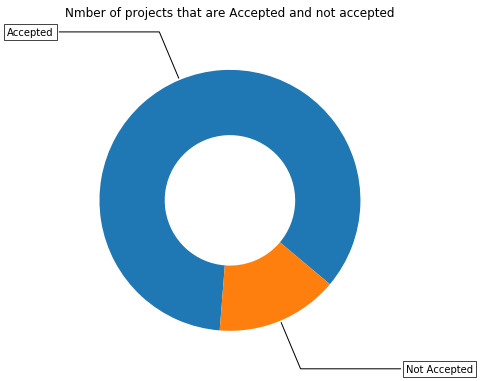

In [8]:
#Reference: https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py

# Analysing the Label column

# Counting the approvals
y_value_counts = project_data['project_is_approved'].value_counts()
print("Number of projects that are approved for funding ", y_value_counts[1], ", (", (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print("Number of projects that are not approved for funding ", y_value_counts[0], ", (", (y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")

# Plotting the chart
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
recipe = ["Accepted", "Not Accepted"]

data = [y_value_counts[1], y_value_counts[0]]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

ax.set_title("Nmber of projects that are Accepted and not accepted\n")

plt.show()

## NOTE:
1. From the above chart we can conclude that 85% (approx) of the projects that were proposed were approved and 15% (aprox) didn't get the approval.

## Univariate Analysis

### 1. school_state

In [9]:
# Pandas dataframe groupby count, mean: https://stackoverflow.com/a/19385591/4084039

temp = pd.DataFrame(project_data.groupby("school_state")["project_is_approved"].apply(np.mean)).reset_index()
# if you have data which contain only 0 and 1, then the mean = percentage (think about it)
temp.columns = ['state_code', 'num_proposals']

In [10]:
# How to plot US state heatmap: https://datascience.stackexchange.com/a/9620

'''scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]'''

data = [ dict(
        type='choropleth',
        #colorscale = scl,
        autocolorscale = True,
        locations = temp['state_code'],
        z = temp['num_proposals'].astype(float),
        locationmode = 'USA-states',
        text = temp['state_code'],
        marker = dict(line = dict (color = 'rgb(255,255,255)',width = 2)),
        colorbar = dict(title = "% of pro")
    ) ]

layout = dict(
        title = 'Project Proposals % of Acceptance Rate by US States',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
        ),
    )

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='us-map-heat-map')

## NOTE:
1. The above figure clearly demonstrates the states which had the higest number of acceptance rate. The darker regions shows the highest selection percentage and if we hover over the states we can clearly see the percentage of acceptance rate.

In [11]:
# Comparison of the top 5 and the bottom 5 states (acceptance rate)

# https://www.csi.cuny.edu/sites/default/files/pdf/administration/ops/2letterstabbrev.pdf
temp.sort_values(by=['num_proposals'], inplace=True)
print("States with lowest % approvals\n")
print(temp.head(5))
print('\n','='*50)
print("\nStates with highest % approvals")
print(temp.tail(5))

States with lowest % approvals

   state_code  num_proposals
46         VT       0.800000
7          DC       0.802326
43         TX       0.813142
26         MT       0.816327
18         LA       0.831245


States with highest % approvals
   state_code  num_proposals
30         NH       0.873563
35         OH       0.875152
47         WA       0.876178
28         ND       0.888112
8          DE       0.897959


## NOTE:
1. The average acceptance rate of the project is 85%
2. Delaware(DE) has the highest rate of acceptance and Vermont(VT) has the lowest
3. There is a lot of variation in the project acceptance percentage but the percentage is more than 80% overall for all the states.
4. State code is a useful feature as it has some variability which can help in prediction of the approval of the project.

## Defining functions used for plotting:

In [12]:
#Reference: stacked bar plots matplotlib: https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html

def stack_plot(data, xtick, col2='project_is_approved', col3='total'):
    ind = np.arange(data.shape[0])
    
    plt.figure(figsize=(20,5))
    p1 = plt.bar(ind, data[col3].values)
    p2 = plt.bar(ind, data[col2].values)

    plt.ylabel('Projects')
    plt.title('Number of projects aproved vs rejected')
    plt.xticks(ind, list(data[xtick].values))
    plt.legend((p1[0], p2[0]), ('total', 'accepted'))
    plt.show()

In [13]:
def univariate_barplots(data, col1, col2='project_is_approved', top=False):
    # Count number of zeros in dataframe python: https://stackoverflow.com/a/51540521/4084039
    temp = pd.DataFrame(project_data.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()

    # Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039
    # https://stackoverflow.com/questions/44635626/rename-result-columns-from-pandas-aggregation-futurewarning-using-a-dict-with
    temp['total'] = pd.DataFrame(project_data.groupby(col1)[col2].agg([('total','count')])).reset_index()['total']
    temp['Avg'] = pd.DataFrame(project_data.groupby(col1)[col2].agg([('Avg','mean')])).reset_index()['Avg']
    
    temp.sort_values(by=['total'],inplace=True, ascending=False)
    
    if top:
        temp = temp[0:top]
    
    stack_plot(temp, xtick=col1, col2=col2, col3='total')
    print(temp.head(5))
    print("="*50)
    print(temp.tail(5))

### Barplots for school_state

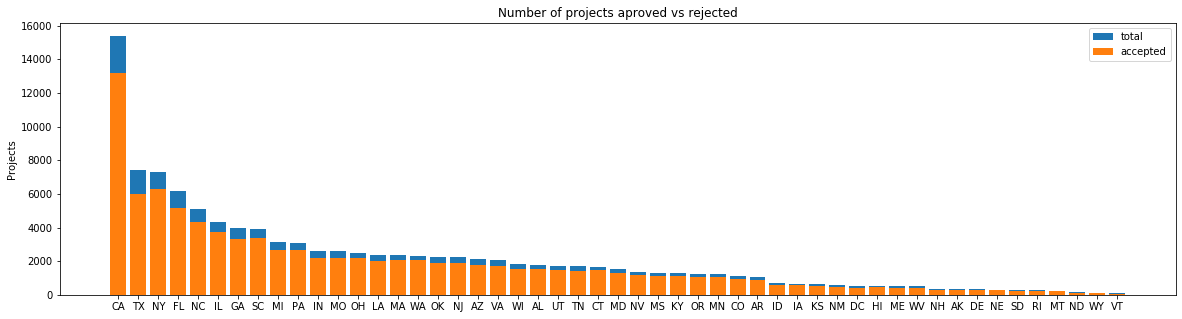

   school_state  project_is_approved  total       Avg
4            CA                13205  15388  0.858136
43           TX                 6014   7396  0.813142
34           NY                 6291   7318  0.859661
9            FL                 5144   6185  0.831690
27           NC                 4353   5091  0.855038
   school_state  project_is_approved  total       Avg
39           RI                  243    285  0.852632
26           MT                  200    245  0.816327
28           ND                  127    143  0.888112
50           WY                   82     98  0.836735
46           VT                   64     80  0.800000


In [14]:
univariate_barplots(project_data, 'school_state', 'project_is_approved', False)

## NOTE:
1. From the above numerical data we can see that CA has the largest number of submissions and on average 85% of it's projects get approved.
2. Though ND doesn't have huge project submissions but the approval rate is very high i.e. 88%
3. There is a variability in the number of project submitted per state.
4. CA and TX has most number of submissions because there must be many schools and a huge population living over there.
5. VT has the lowest number of submission as well as the approval rate.
6. The approval rate is more than 80% for all states.

### 2. teacher_prefix

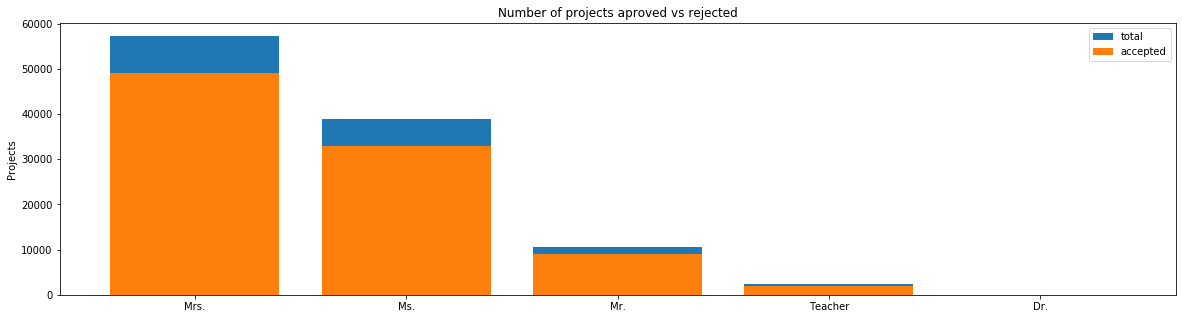

  teacher_prefix  project_is_approved  total       Avg
2           Mrs.                48997  57269  0.855559
3            Ms.                32860  38955  0.843537
1            Mr.                 8960  10648  0.841473
4        Teacher                 1877   2360  0.795339
0            Dr.                    9     13  0.692308
  teacher_prefix  project_is_approved  total       Avg
2           Mrs.                48997  57269  0.855559
3            Ms.                32860  38955  0.843537
1            Mr.                 8960  10648  0.841473
4        Teacher                 1877   2360  0.795339
0            Dr.                    9     13  0.692308


In [15]:
univariate_barplots(project_data, 'teacher_prefix', 'project_is_approved' , top=False)

## NOTE:
1. For the prefix [Mrs, Ms, Mr] there is a higher approval rate (85%, 84%, 84%) respectively.
2. For the prefix Teacher and Dr. the rate of successful approval is low and the number of projects submission is low as well.

### 3. project_grade_category

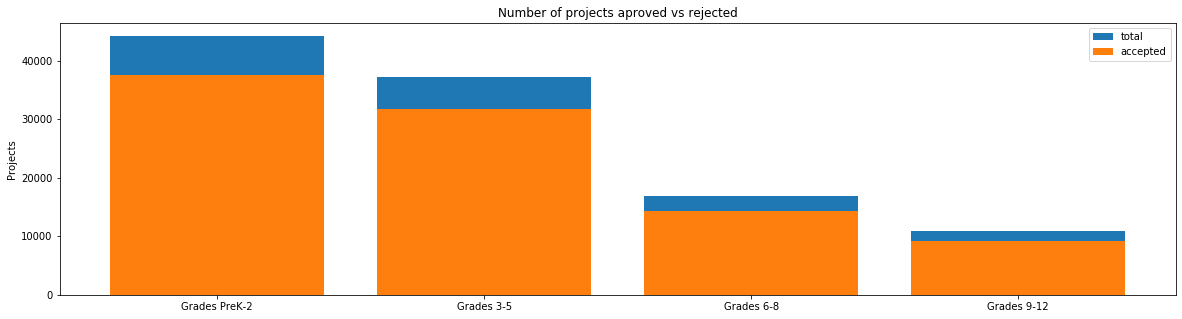

  project_grade_category  project_is_approved  total       Avg
3          Grades PreK-2                37536  44225  0.848751
0             Grades 3-5                31729  37137  0.854377
1             Grades 6-8                14258  16923  0.842522
2            Grades 9-12                 9183  10963  0.837636
  project_grade_category  project_is_approved  total       Avg
3          Grades PreK-2                37536  44225  0.848751
0             Grades 3-5                31729  37137  0.854377
1             Grades 6-8                14258  16923  0.842522
2            Grades 9-12                 9183  10963  0.837636


In [16]:
univariate_barplots(project_data, 'project_grade_category', 'project_is_approved', top=False)

## NOTE:
1. The higher grades (9-12) has lower number of project submissions than the lower grades (PreK-2)
2. The approval rate for lower grades are more than the higher grades. So we see a variation in the approvals.
3. This feature can be important for us.

### 4. project_subject_categories

In [17]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())

In [18]:
# Creating a new columns in project_data and dropping another
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)
project_data.head(2)

id                        teacher_id teacher_prefix school_state  \
55660  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           Mrs.           CA   
76127  p043609  3f60494c61921b3b43ab61bdde2904df            Ms.           UT   

                     Date project_grade_category  \
55660 2016-04-27 00:27:36          Grades PreK-2   
76127 2016-04-27 00:31:25             Grades 3-5   

                 project_subject_subcategories  \
55660  Applied Sciences, Health & Life Science   
76127                            Special Needs   

                                      project_title  \
55660  Engineering STEAM into the Primary Classroom   
76127                       Sensory Tools for Focus   

                                         project_essay_1  \
55660  I have been fortunate enough to use the Fairy ...   
76127  Imagine being 8-9 years old. You're in your th...   

                                         project_essay_2  \
55660  My students come from a variety of backgrounds...   
76127  Most of my students have autism, anxiety, anot...   

                                         project_essay_3  \
55660  Each month I try to do several science or STEM...   
76127  It is tough to do more than one thing at a tim...   

                                         project_essay_4  \
55660  It is challenging to develop high quality scie...   
76127  When my students are able to calm themselves d...   

                                project_resource_summary  \
55660  My students need STEM kits to learn critical s...   
76127  My students need Boogie Boards for quiet senso...   

       teacher_number_of_previously_posted_projects  project_is_approved  \
55660                                            53                    1   
76127                                             4                    1   

      clean_categories  
55660     Math_Science  
76127     SpecialNeeds

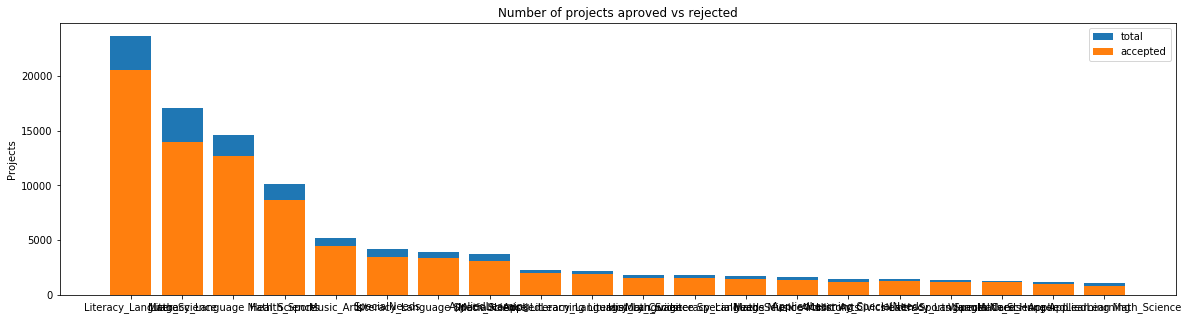

                  clean_categories  project_is_approved  total       Avg
24               Literacy_Language                20520  23655  0.867470
32                    Math_Science                13991  17072  0.819529
28  Literacy_Language Math_Science                12725  14636  0.869432
8                    Health_Sports                 8640  10177  0.848973
40                      Music_Arts                 4429   5180  0.855019
                    clean_categories  project_is_approved  total       Avg
19  History_Civics Literacy_Language                 1271   1421  0.894441
14        Health_Sports SpecialNeeds                 1215   1391  0.873472
50                Warmth Care_Hunger                 1212   1309  0.925898
33      Math_Science AppliedLearning                 1019   1220  0.835246
4       AppliedLearning Math_Science                  855   1052  0.812738


In [19]:
univariate_barplots(project_data, 'clean_categories', 'project_is_approved', top=20)

## NOTE:
1. If the project belongs to a joint category (for eg. Literacy_Language Math_Science - 86%) the chances of getting the approval is high compared to the individual category Math_Science (81% success).
2. Categories like "Warmth Care_Hunger" have a very high chances of getting the approval (average - 92%) which means the donors don't want the childern to starve and this is the most important area where they want to donate.
3. The least approval is of Math_Science category with just 81% successful approval. This can be viewed as the donors are not much interested in donating in this category.
4. There is a lot of difference and variations in this attribute and we can use this variation to predict the approval rate.

### Viewing the individual Categories

In [20]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

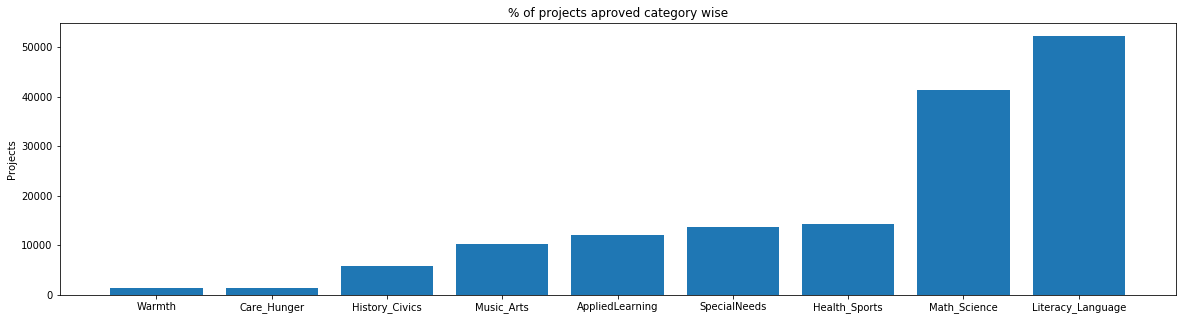

In [21]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(sorted_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_cat_dict.values()))

plt.ylabel('Projects')
plt.title('% of projects aproved category wise')
plt.xticks(ind, list(sorted_cat_dict.keys()))
plt.show()

In [22]:
for i, j in sorted_cat_dict.items():
    print("{:20} :{:10}".format(i,j))

Warmth               :      1388
Care_Hunger          :      1388
History_Civics       :      5914
Music_Arts           :     10293
AppliedLearning      :     12135
SpecialNeeds         :     13642
Health_Sports        :     14223
Math_Science         :     41421
Literacy_Language    :     52239


## NOTE:
1. As we can see the Literacy_Language category has the highest number of project submission.
2. Warmth has the least number of project submission.
3. There is a huge variation in the occurance of these category.
4. This can help us distinguish the approval rate.

### 5. project_subject_subcategories

In [23]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

In [24]:
# Creating a new columns in project_data and dropping another
project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)
project_data.head(2)

id                        teacher_id teacher_prefix school_state  \
55660  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           Mrs.           CA   
76127  p043609  3f60494c61921b3b43ab61bdde2904df            Ms.           UT   

                     Date project_grade_category  \
55660 2016-04-27 00:27:36          Grades PreK-2   
76127 2016-04-27 00:31:25             Grades 3-5   

                                      project_title  \
55660  Engineering STEAM into the Primary Classroom   
76127                       Sensory Tools for Focus   

                                         project_essay_1  \
55660  I have been fortunate enough to use the Fairy ...   
76127  Imagine being 8-9 years old. You're in your th...   

                                         project_essay_2  \
55660  My students come from a variety of backgrounds...   
76127  Most of my students have autism, anxiety, anot...   

                                         project_essay_3  \
55660  Each month I try to do several science or STEM...   
76127  It is tough to do more than one thing at a tim...   

                                         project_essay_4  \
55660  It is challenging to develop high quality scie...   
76127  When my students are able to calm themselves d...   

                                project_resource_summary  \
55660  My students need STEM kits to learn critical s...   
76127  My students need Boogie Boards for quiet senso...   

       teacher_number_of_previously_posted_projects  project_is_approved  \
55660                                            53                    1   
76127                                             4                    1   

      clean_categories                 clean_subcategories  
55660     Math_Science  AppliedSciences Health_LifeScience  
76127     SpecialNeeds                        SpecialNeeds

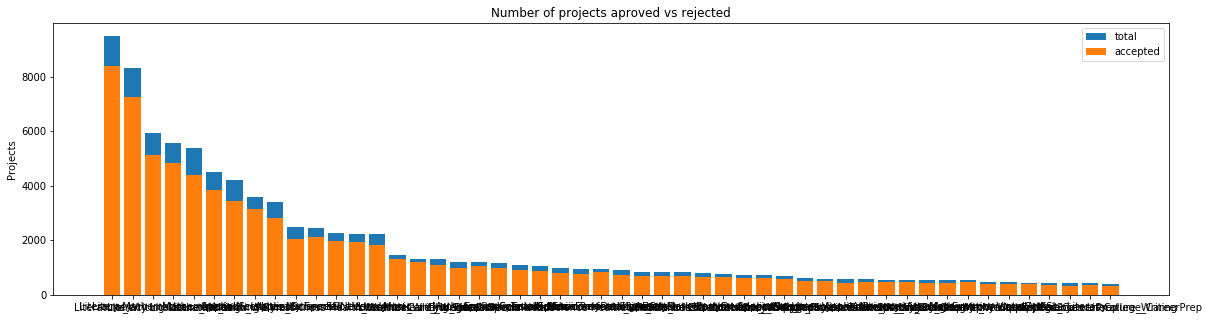

                clean_subcategories  project_is_approved  total       Avg
317                        Literacy                 8371   9486  0.882458
319            Literacy Mathematics                 7260   8325  0.872072
331  Literature_Writing Mathematics                 5140   5923  0.867803
318     Literacy Literature_Writing                 4823   5571  0.865733
342                     Mathematics                 4385   5379  0.815207
                    clean_subcategories  project_is_approved  total       Avg
196       EnvironmentalScience Literacy                  389    444  0.876126
127                                 ESL                  349    421  0.828979
79                   College_CareerPrep                  343    421  0.814727
17   AppliedSciences Literature_Writing                  361    420  0.859524
3    AppliedSciences College_CareerPrep                  330    405  0.814815


In [25]:
univariate_barplots(project_data, 'clean_subcategories', 'project_is_approved', top=50)

## NOTE:
1. Donors are more interested in the subcategory - Literacy. This is why where ever there is a joint category with Literacy the approval rate is high.
2. Mathematics subcategory has the least approval rate of all. This can be thought as the Donors are not so interested in projects related to mathemaics and they intend to donate for more general purpose projects like Literacy related projects

### Viewing the individual subcategories

In [26]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())

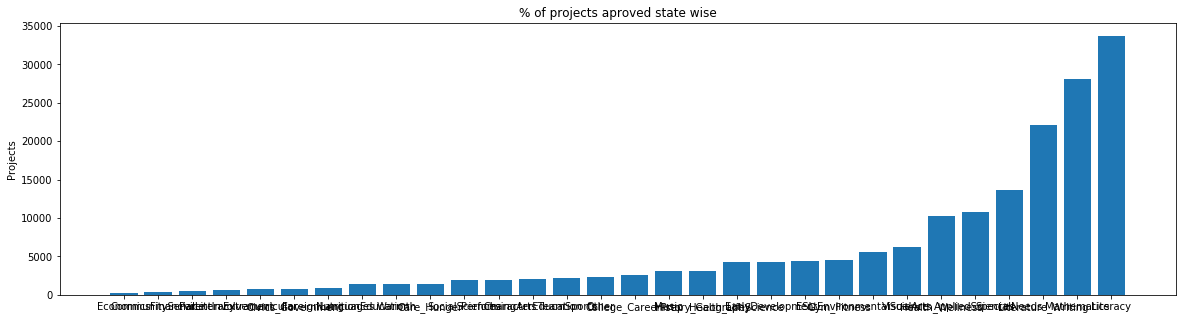

In [27]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(sorted_sub_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_sub_cat_dict.values()))

plt.ylabel('Projects')
plt.title('% of projects aproved state wise')
plt.xticks(ind, list(sorted_sub_cat_dict.keys()))
plt.show()

In [28]:
for i, j in sorted_sub_cat_dict.items():
    print("{:20} :{:10}".format(i,j))

Economics            :       269
CommunityService     :       441
FinancialLiteracy    :       568
ParentInvolvement    :       677
Extracurricular      :       810
Civics_Government    :       815
ForeignLanguages     :       890
NutritionEducation   :      1355
Warmth               :      1388
Care_Hunger          :      1388
SocialSciences       :      1920
PerformingArts       :      1961
CharacterEducation   :      2065
TeamSports           :      2192
Other                :      2372
College_CareerPrep   :      2568
Music                :      3145
History_Geography    :      3171
Health_LifeScience   :      4235
EarlyDevelopment     :      4254
ESL                  :      4367
Gym_Fitness          :      4509
EnvironmentalScience :      5591
VisualArts           :      6278
Health_Wellness      :     10234
AppliedSciences      :     10816
SpecialNeeds         :     13642
Literature_Writing   :     22179
Mathematics          :     28074
Literacy             :     33700


## NOTE:
1. We can clearly see the donors are very much interested in Literay subcategory and because of that the approval rate is very high.
2. This feature can help us in knowing the interest of the donors and accordingly we can predict the approval rates

### 6. Text features (Title)

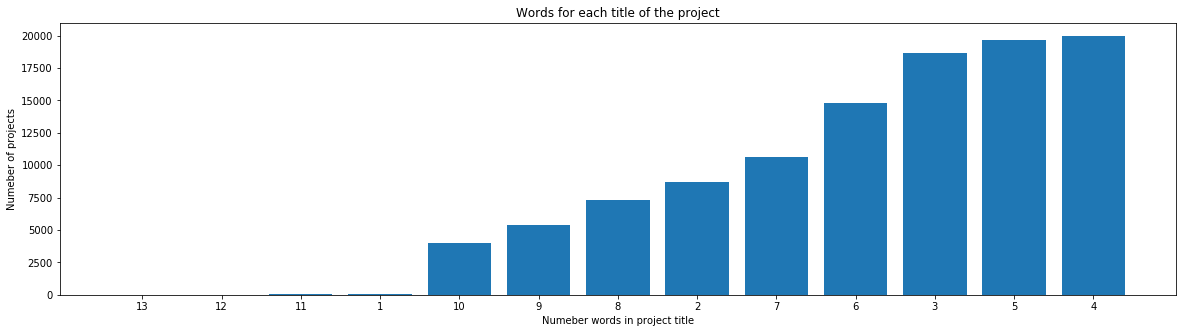

In [29]:
#How to calculate number of words in a string in DataFrame: https://stackoverflow.com/a/37483537/4084039
word_count = project_data['project_title'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Numeber of projects')
plt.xlabel('Numeber words in project title')
plt.title('Words for each title of the project')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

In [30]:
# Counting the words in the title of the approved Titles and the rejected Titles
approved_title_word_count = project_data[project_data['project_is_approved']==1]['project_title'].str.split().apply(len)
approved_title_word_count = approved_title_word_count.values

rejected_title_word_count = project_data[project_data['project_is_approved']==0]['project_title'].str.split().apply(len)
rejected_title_word_count = rejected_title_word_count.values

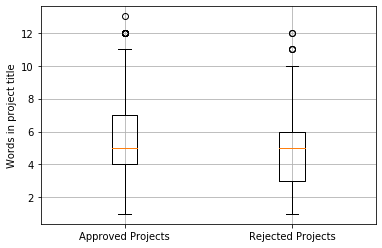

In [31]:
# Plotting the BOX PLOT

# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_title_word_count, rejected_title_word_count])
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project title')
plt.grid()
plt.show()

## NOTE:
1. As we can see in the box plot, the median of the accepted and the rejected titles are almost at the same level.
2. 4-7 word titles have the higher rate of approval.
3. Number of words in the title of approved projects are more than the rejected projects. (as we can see from the histogram and the box plot distribution - percentiles)

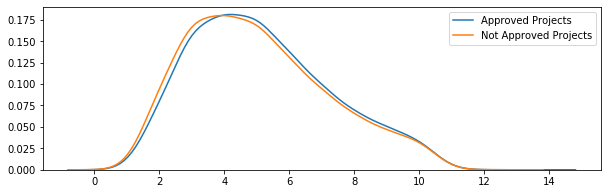

In [32]:
# PDF of the number of words in the title
plt.figure(figsize=(10,3))
sns.kdeplot(approved_title_word_count,label="Approved Projects", bw=0.6)
sns.kdeplot(rejected_title_word_count,label="Not Approved Projects", bw=0.6)
plt.legend()
plt.show()

## NOTE:
1. The approved PDF is slightly ahead of the not approved PDF
2. This shows that there are more words in the title of the approved projects

### 7. Text features (Project Essay's)

In [33]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [34]:
# Counting the words 
approved_word_count = project_data[project_data['project_is_approved']==1]['essay'].str.split().apply(len)
approved_word_count = approved_word_count.values

rejected_word_count = project_data[project_data['project_is_approved']==0]['essay'].str.split().apply(len)
rejected_word_count = rejected_word_count.values

In [35]:
# Box Plot for words in essay

# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_word_count, rejected_word_count])
plt.title('Words for each essay of the project')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project essays')
plt.grid()
plt.show()

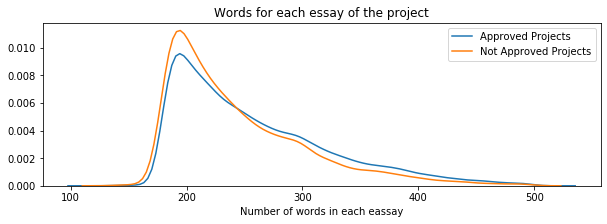

In [36]:
plt.figure(figsize=(10,3))
sns.distplot(approved_word_count, hist=False, label="Approved Projects")
sns.distplot(rejected_word_count, hist=False, label="Not Approved Projects")
plt.title('Words for each essay of the project')
plt.xlabel('Number of words in each eassay')
plt.legend()
plt.show()

## NOTE:
1. Approved projects tends to have slightly more number of words in the project essay. 
2. The PDF and the Box Plot clearly shows that the distribution of Approved projects contains more number of words in it.

### 8. Cost per project

In [37]:
# we get the cost of the project using resource.csv file
resource_data.head(2)

id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

In [38]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

id   price  quantity
0  p000001  459.56         7
1  p000002  515.89        21

In [39]:
# join two dataframes in python: 
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [40]:
approved_price = project_data[project_data['project_is_approved']==1]['price'].values

rejected_price = project_data[project_data['project_is_approved']==0]['price'].values

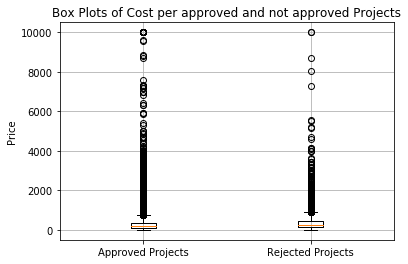

In [41]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_price, rejected_price])
plt.title('Box Plots of Cost per approved and not approved Projects')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Price')
plt.grid()
plt.show()

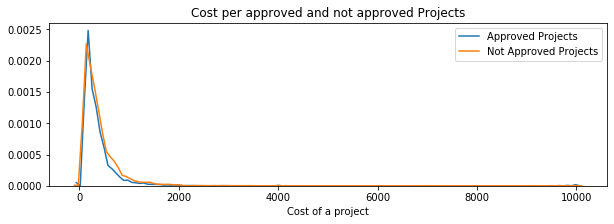

In [42]:
plt.figure(figsize=(10,3))
sns.distplot(approved_price, hist=False, label="Approved Projects")
sns.distplot(rejected_price, hist=False, label="Not Approved Projects")
plt.title('Cost per approved and not approved Projects')
plt.xlabel('Cost of a project')
plt.legend()
plt.show()

## NOTE:
1. There are a lot of outliers in the box plot so it's difficult to draw any conclusion from there
2. The PDF shows that the approved projects tends to cost less than the not approved projects

In [43]:
# Plotting the percentiles

# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable

x = PrettyTable()
x.field_names = ["Percentile", "Approved Projects", "Not Approved Projects"]

for i in range(0,101,5):
    x.add_row([i,np.round(np.percentile(approved_price,i), 3), np.round(np.percentile(rejected_price,i), 3)])
print(x)

+------------+-------------------+-----------------------+
| Percentile | Approved Projects | Not Approved Projects |
+------------+-------------------+-----------------------+
|     0      |        0.66       |          1.97         |
|     5      |       13.59       |          41.9         |
|     10     |       33.88       |         73.67         |
|     15     |        58.0       |         99.109        |
|     20     |       77.38       |         118.56        |
|     25     |       99.95       |        140.892        |
|     30     |       116.68      |         162.23        |
|     35     |      137.232      |        184.014        |
|     40     |       157.0       |        208.632        |
|     45     |      178.265      |        235.106        |
|     50     |       198.99      |        263.145        |
|     55     |       223.99      |         292.61        |
|     60     |       255.63      |        325.144        |
|     65     |      285.412      |         362.39       

## NOTE:
1. From the percentiles we can clearly see that the approved projects have lower cost than the not approved projects
2. Donors intend to donate more on cost efficient projects
3. The price of any project should be less than $10,000

### 9. teacher_number_of_previously_posted_projects

In [44]:
project_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109248 entries, 0 to 109247
Data columns (total 19 columns):
id                                              109248 non-null object
teacher_id                                      109248 non-null object
teacher_prefix                                  109245 non-null object
school_state                                    109248 non-null object
Date                                            109248 non-null datetime64[ns]
project_grade_category                          109248 non-null object
project_title                                   109248 non-null object
project_essay_1                                 109248 non-null object
project_essay_2                                 109248 non-null object
project_essay_3                                 3758 non-null object
project_essay_4                                 3758 non-null object
project_resource_summary                        109248 non-null object
teacher_number_of_previously_post

In [45]:
project_data.head(2)

id                        teacher_id teacher_prefix school_state  \
0  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           Mrs.           CA   
1  p043609  3f60494c61921b3b43ab61bdde2904df            Ms.           UT   

                 Date project_grade_category  \
0 2016-04-27 00:27:36          Grades PreK-2   
1 2016-04-27 00:31:25             Grades 3-5   

                                  project_title  \
0  Engineering STEAM into the Primary Classroom   
1                       Sensory Tools for Focus   

                                     project_essay_1  \
0  I have been fortunate enough to use the Fairy ...   
1  Imagine being 8-9 years old. You're in your th...   

                                     project_essay_2  \
0  My students come from a variety of backgrounds...   
1  Most of my students have autism, anxiety, anot...   

                                     project_essay_3  \
0  Each month I try to do several science or STEM...   
1  It is tough to do more than one thing at a tim...   

                                     project_essay_4  \
0  It is challenging to develop high quality scie...   
1  When my students are able to calm themselves d...   

                            project_resource_summary  \
0  My students need STEM kits to learn critical s...   
1  My students need Boogie Boards for quiet senso...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                            53                    1   
1                                             4                    1   

  clean_categories                 clean_subcategories  \
0     Math_Science  AppliedSciences Health_LifeScience   
1     SpecialNeeds                        SpecialNeeds   

                                               essay   price  quantity  
0  I have been fortunate enough to use the Fairy ...  725.05         4  
1  Imagine being 8-9 years old. You're in your th...  213.03         8

## NOTE:
 1. This column tell us about the Number of project applications previously submitted by the same teacher.
 2. It has integer values as the info() tells us

In [46]:
project_data['teacher_number_of_previously_posted_projects'].describe()

count    109248.000000
mean         11.153165
std          27.777154
min           0.000000
25%           0.000000
50%           2.000000
75%           9.000000
max         451.000000
Name: teacher_number_of_previously_posted_projects, dtype: float64

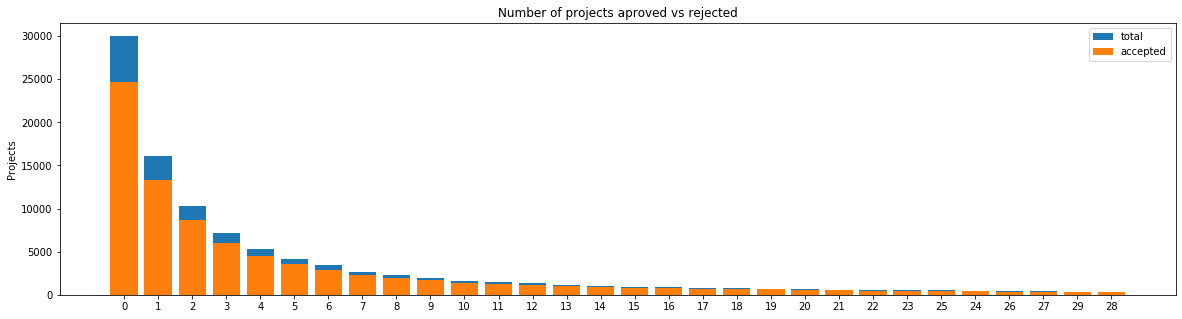

   teacher_number_of_previously_posted_projects  project_is_approved  total  \
0                                             0                24652  30014   
1                                             1                13329  16058   
2                                             2                 8705  10350   
3                                             3                 5997   7110   
4                                             4                 4452   5266   

        Avg  
0  0.821350  
1  0.830054  
2  0.841063  
3  0.843460  
4  0.845423  
    teacher_number_of_previously_posted_projects  project_is_approved  total  \
24                                            24                  405    449   
26                                            26                  378    445   
27                                            27                  352    394   
29                                            29                  336    370   
28                                       

In [47]:
univariate_barplots(project_data, 'teacher_number_of_previously_posted_projects', 'project_is_approved', top=30)

## NOTE:
1. The number of 1st time project submission is very high i.e. teachers with no previous submissions are 30014 in total and the rate of approvement 82%
2. Teachers with higher number of projects submission have a better chance of getting the approval. For eg. The teacher with 24 submissions has a approval rate of 90%.
3. We can say that the donors actually trust those teaches who have more number of previous posted projects.

In [48]:
# Separating the approved projects based on the previously posted projects by the same teacher 
approved_techer_project = project_data[project_data['project_is_approved']==1]['teacher_number_of_previously_posted_projects'].values

rejected_techer_project = project_data[project_data['project_is_approved']==0]['teacher_number_of_previously_posted_projects'].values

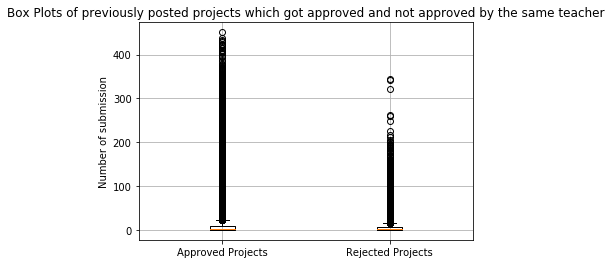

In [49]:
# Making the boxplot

# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_techer_project, rejected_techer_project])
plt.title('Box Plots of previously posted projects which got approved and not approved by the same teacher')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Number of submission')
plt.grid()
plt.show()

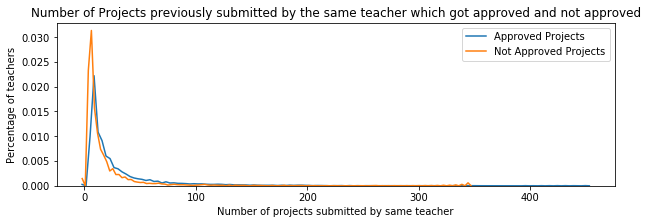

In [50]:
#PDF of the techer_projects

plt.figure(figsize=(10,3))
sns.distplot(approved_techer_project, hist=False, label="Approved Projects")
sns.distplot(rejected_techer_project, hist=False, label="Not Approved Projects")
plt.title('Number of Projects previously submitted by the same teacher which got approved and not approved')
plt.xlabel('Number of projects submitted by same teacher')
plt.ylabel('Percentage of teachers')
plt.legend()
plt.show()

## NOTE:
1. There are very few teachers who submitted a large number of projects. 
2. As the PDF shows there are 0-10 number of projects submitted by most of the teachers and the approval rate is low
3. Most teachers who submitted 0 projects previously didn't get a approval on their 1st submission
5. Teachers who have higher number of submissions get a approval on new submissions
6. The PDF for the approved projects is a bit longer at the end than the not approved projects

In [51]:
# Plotting the percentiles

# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable

x = PrettyTable()
x.field_names = ["Percentile", "Approved Projects", "Not Approved Projects"]

for i in range(0,101,5):
    x.add_row([i,np.round(np.percentile(approved_techer_project,i), 3), np.round(np.percentile(rejected_techer_project,i), 3)])
print(x)

+------------+-------------------+-----------------------+
| Percentile | Approved Projects | Not Approved Projects |
+------------+-------------------+-----------------------+
|     0      |        0.0        |          0.0          |
|     5      |        0.0        |          0.0          |
|     10     |        0.0        |          0.0          |
|     15     |        0.0        |          0.0          |
|     20     |        0.0        |          0.0          |
|     25     |        0.0        |          0.0          |
|     30     |        1.0        |          0.0          |
|     35     |        1.0        |          1.0          |
|     40     |        1.0        |          1.0          |
|     45     |        2.0        |          1.0          |
|     50     |        2.0        |          2.0          |
|     55     |        3.0        |          2.0          |
|     60     |        4.0        |          3.0          |
|     65     |        5.0        |          3.0         

## NOTE:
1. Teachers who have a previous submission tend to have new projects getting approved easily
2. The 25th, 50th and 75th percentile have a low chance of getting approval i.e new submissions are not getting approvals easily
3. Highest number of submissions is 451 submissions.

### 10. project_resource_summary

In [52]:
project_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109248 entries, 0 to 109247
Data columns (total 19 columns):
id                                              109248 non-null object
teacher_id                                      109248 non-null object
teacher_prefix                                  109245 non-null object
school_state                                    109248 non-null object
Date                                            109248 non-null datetime64[ns]
project_grade_category                          109248 non-null object
project_title                                   109248 non-null object
project_essay_1                                 109248 non-null object
project_essay_2                                 109248 non-null object
project_essay_3                                 3758 non-null object
project_essay_4                                 3758 non-null object
project_resource_summary                        109248 non-null object
teacher_number_of_previously_post

In [53]:
project_data['project_resource_summary'].describe()

count                                                109248
unique                                               108324
top       My students need electronic tablets to do all ...
freq                                                     48
Name: project_resource_summary, dtype: object

## NOTE:
1. This column is a text column containing the text data for resource summary.
2. Number of unique words: 108324
3. Frequency of words: 48

In [54]:
project_data['project_resource_summary'].head()

0    My students need STEM kits to learn critical s...
1    My students need Boogie Boards for quiet senso...
2    My students need a mobile listening center to ...
3    My students need flexible seating in the class...
4    My students need copies of the New York Times ...
Name: project_resource_summary, dtype: object

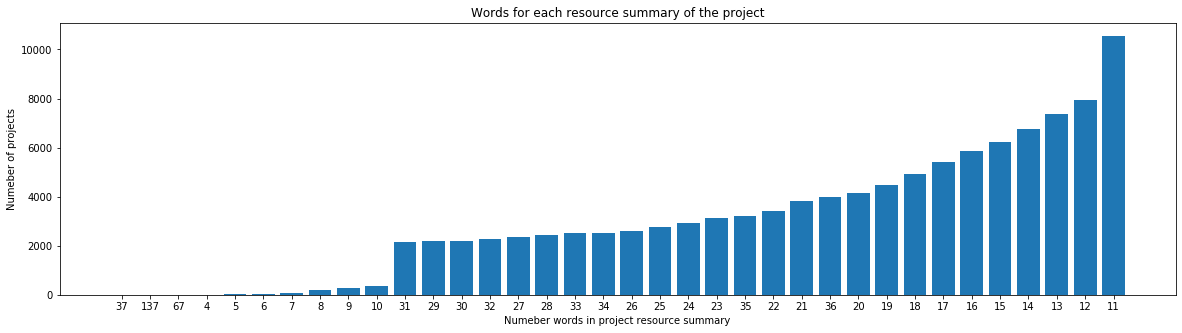

In [55]:
# Counting the number of words in each project summary
#How to calculate number of words in a string in DataFrame: https://stackoverflow.com/a/37483537/4084039
word_count = project_data['project_resource_summary'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Numeber of projects')
plt.xlabel('Numeber words in project resource summary')
plt.title('Words for each resource summary of the project')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

## NOTE:
1. Most of the projects have their words range between 11-20
2. The highest number of words in most of the projects is 11
3. There are very few projects which has words between 4-10 or too high resource descriptions with words more than 37

In [56]:
# Counting the words in the resource_summary of the approved resource_summary and the rejected resource_summary
approved_resource_summary_word_count = project_data[project_data['project_is_approved']==1]['project_resource_summary'].str.split().apply(len)
approved_resource_summary_word_count = approved_resource_summary_word_count.values

rejected_resource_summary_word_count = project_data[project_data['project_is_approved']==0]['project_resource_summary'].str.split().apply(len)
rejected_resource_summary_word_count = rejected_resource_summary_word_count.values

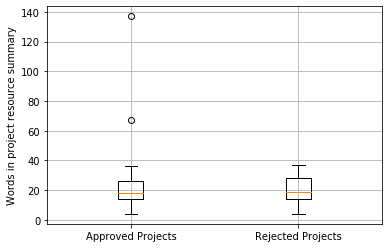

In [57]:
# Plotting the BOX PLOT

# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_resource_summary_word_count, rejected_resource_summary_word_count])
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project resource summary')
plt.grid()
plt.show()

## NOTE:
1. Meadian is almost similar for both of the approved projects and not approved ones
2. The word distribution in the rejected projects are a bit higher (15-30)

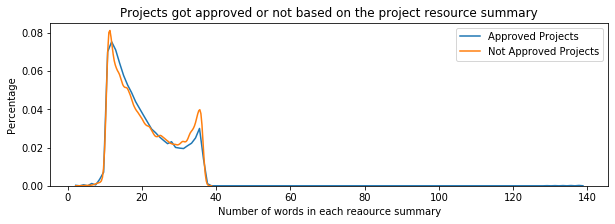

In [58]:
# PDF of the number of words in the project resource summary
plt.figure(figsize=(10,3))
sns.kdeplot(approved_resource_summary_word_count,label="Approved Projects", bw=0.6)
sns.kdeplot(rejected_resource_summary_word_count,label="Not Approved Projects", bw=0.6)
plt.legend()
plt.title('Projects got approved or not based on the project resource summary')
plt.xlabel('Number of words in each reaource summary')
plt.ylabel('Percentage')
plt.show()

## NOTE:
1. Summaries with very less number of words(0-10) are most likely to get rejected.
2. Summaries with words more than 40 are surely getting approved but that percentage is near to 0
3. Approval decreases as the number of words increase between 11-31 and then it starts increasing up to 36 and the decreases sharply

### Finding the digits in the resource summaries (ASSIGNMENT)

In [59]:
# Resource: https://stackoverflow.com/questions/12005558/python-find-digits-in-a-string
def digit_present(text):
    count = 0
    for i in text:
        if i.isdigit():
            count += 1
    
    if count > 0:
        return 1
    else:
        return 0

In [60]:
# Applying the function to the dataframe and creating a new column in the project_data
project_data['numerical_presence'] = project_data['project_resource_summary'].apply(digit_present)

In [61]:
project_data.tail(2)

id                        teacher_id teacher_prefix school_state  \
109246  p184393  65545a295267ad9df99f26f25c978fd0           Mrs.           HI   
109247  p028318  1fff5a88945be8b2c728c6a85c31930f           Mrs.           CA   

                      Date project_grade_category  \
109246 2017-04-30 23:27:07            Grades 9-12   
109247 2017-04-30 23:45:08          Grades PreK-2   

                         project_title  \
109246  Cricket Cutting Machine Needed   
109247                   News for Kids   

                                          project_essay_1  \
109246  I teach many different types of students.  My ...   
109247  My first graders are eager to learn about the ...   

                                          project_essay_2 project_essay_3  \
109246  This cricket cutting machine will be used for ...             NaN   
109247  I have used these magazines in the past, and k...             NaN   

       project_essay_4                           project_resource_summary  \
109246             NaN  My students need a cricket machine to help mak...   
109247             NaN  My students need a subscription to Scholastic ...   

        teacher_number_of_previously_posted_projects  project_is_approved  \
109246                                             1                    1   
109247                                             2                    1   

         clean_categories          clean_subcategories  \
109246       Math_Science           Health_LifeScience   
109247  Literacy_Language  Literacy Literature_Writing   

                                                    essay   price  quantity  \
109246  I teach many different types of students.  My ...  287.73         4   
109247  My first graders are eager to learn about the ...    5.50        25   

        numerical_presence  
109246                   0  
109247                   0

### Analysing the numerical_presence column

In [62]:
project_data['numerical_presence'].describe()

count    109248.000000
mean          0.144222
std           0.351317
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: numerical_presence, dtype: float64

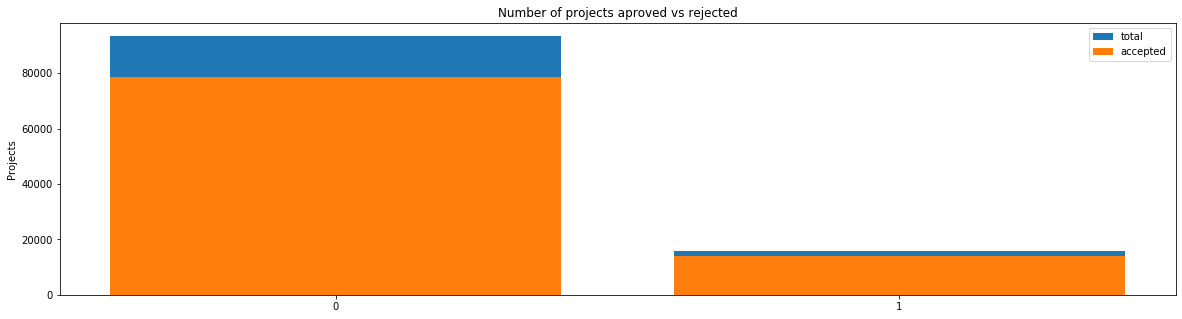

   numerical_presence  project_is_approved  total       Avg
0                   0                78616  93492  0.840885
1                   1                14090  15756  0.894263
   numerical_presence  project_is_approved  total       Avg
0                   0                78616  93492  0.840885
1                   1                14090  15756  0.894263


In [63]:
univariate_barplots(project_data, 'numerical_presence', 'project_is_approved', top=False)

## NOTE: 
1. The percentage of approval with the presence of a numerical digit is 89% on an average.
2. The summeries which conatins numerical digits are significantly low which means most of he summaries in the resource summaries column doesn't have a digit present in it. If there is a digit present the chance of getting approved is very high.
3. Even though there is not much digit present in the resource summary still the projects are getting selected with a average of 84% success rate.

In [64]:
# Separating the approved projects based on the numerical presence
approved_project_num_present = project_data[project_data['project_is_approved']==1]['numerical_presence'].values

rejected_project_num_present = project_data[project_data['project_is_approved']==0]['numerical_presence'].values

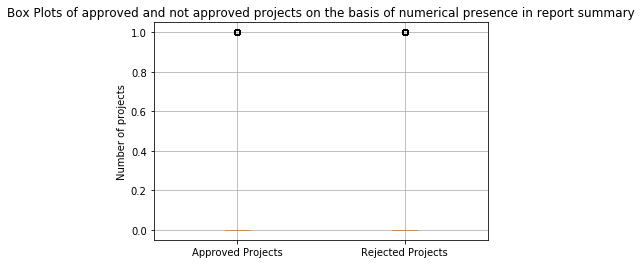

In [65]:
# Making the boxplot

# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_project_num_present, rejected_project_num_present])
plt.title('Box Plots of approved and not approved projects on the basis of numerical presence in report summary')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Number of projects')
plt.grid()
plt.show()

## NOTE:
1. From the box plot we can say that the median of the approval of the projects on the baisis of numerical digit presence is 0. That means that there are very less projects with numerical digits present in them.

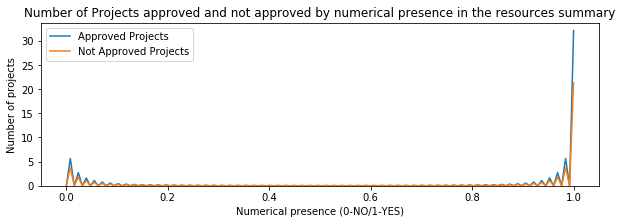

In [66]:
#PDF of the numerical_presence

plt.figure(figsize=(10,3))
sns.distplot(approved_project_num_present, hist=False, label="Approved Projects")
sns.distplot(rejected_project_num_present, hist=False, label="Not Approved Projects")
plt.title('Number of Projects approved and not approved by numerical presence in the resources summary')
plt.xlabel('Numerical presence (0-NO/1-YES)')
plt.ylabel('Number of projects')
plt.legend()
plt.show()

## NOTE:
1. We can see that the number of projects which has the numerical presence got approval as per the PDF
2. There are very less projects which didn't get approval even with the presence of numerical digits.

In [67]:
# Plotting the percentiles

# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable

x = PrettyTable()
x.field_names = ["Percentile", "Approved Projects", "Not Approved Projects"]

for i in range(0,101,5):
    x.add_row([i,np.round(np.percentile(approved_project_num_present,i), 3), np.round(np.percentile(rejected_project_num_present,i), 3)])
print(x)

+------------+-------------------+-----------------------+
| Percentile | Approved Projects | Not Approved Projects |
+------------+-------------------+-----------------------+
|     0      |        0.0        |          0.0          |
|     5      |        0.0        |          0.0          |
|     10     |        0.0        |          0.0          |
|     15     |        0.0        |          0.0          |
|     20     |        0.0        |          0.0          |
|     25     |        0.0        |          0.0          |
|     30     |        0.0        |          0.0          |
|     35     |        0.0        |          0.0          |
|     40     |        0.0        |          0.0          |
|     45     |        0.0        |          0.0          |
|     50     |        0.0        |          0.0          |
|     55     |        0.0        |          0.0          |
|     60     |        0.0        |          0.0          |
|     65     |        0.0        |          0.0         

## NOTE:
1. The percentiles doesn't give any valuable information because there are binary values present in the numerical_presence column.
2. The box plot too couldn't give any valuable information as it also uses the percentiles and the 25th, 50th and 75th percentiles are 0

## 2.3 Text preprocessing

### 1. Essay Text

In [68]:
project_data.head(2)

id                        teacher_id teacher_prefix school_state  \
0  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           Mrs.           CA   
1  p043609  3f60494c61921b3b43ab61bdde2904df            Ms.           UT   

                 Date project_grade_category  \
0 2016-04-27 00:27:36          Grades PreK-2   
1 2016-04-27 00:31:25             Grades 3-5   

                                  project_title  \
0  Engineering STEAM into the Primary Classroom   
1                       Sensory Tools for Focus   

                                     project_essay_1  \
0  I have been fortunate enough to use the Fairy ...   
1  Imagine being 8-9 years old. You're in your th...   

                                     project_essay_2  \
0  My students come from a variety of backgrounds...   
1  Most of my students have autism, anxiety, anot...   

                                     project_essay_3  \
0  Each month I try to do several science or STEM...   
1  It is tough to do more than one thing at a tim...   

                                     project_essay_4  \
0  It is challenging to develop high quality scie...   
1  When my students are able to calm themselves d...   

                            project_resource_summary  \
0  My students need STEM kits to learn critical s...   
1  My students need Boogie Boards for quiet senso...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                            53                    1   
1                                             4                    1   

  clean_categories                 clean_subcategories  \
0     Math_Science  AppliedSciences Health_LifeScience   
1     SpecialNeeds                        SpecialNeeds   

                                               essay   price  quantity  \
0  I have been fortunate enough to use the Fairy ...  725.05         4   
1  Imagine being 8-9 years old. You're in your th...  213.03         8   

   numerical_presence  
0                   0  
1                   0

In [69]:
# printing some random essays.
print(project_data['essay'].values[0])
print('\n',"="*120)
print(project_data['essay'].values[150])
print('\n',"="*120)
print(project_data['essay'].values[1000])
print('\n',"="*120)
print(project_data['essay'].values[20000])
print('\n',"="*120)
print(project_data['essay'].values[99999])
print('\n',"="*120)

I have been fortunate enough to use the Fairy Tale STEM kits in my classroom as well as the STEM journals, which my students really enjoyed.  I would love to implement more of the Lakeshore STEM kits in my classroom for the next school year as they provide excellent and engaging STEM lessons.My students come from a variety of backgrounds, including language and socioeconomic status.  Many of them don't have a lot of experience in science and engineering and these kits give me the materials to provide these exciting opportunities for my students.Each month I try to do several science or STEM/STEAM projects.  I would use the kits and robot to help guide my science instruction in engaging and meaningful ways.  I can adapt the kits to my current language arts pacing guide where we already teach some of the material in the kits like tall tales (Paul Bunyan) or Johnny Appleseed.  The following units will be taught in the next school year where I will implement these kits: magnets, motion, si

## NOTE:
1. There are a lot of unwanted symbols which we have to remove.

In [70]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [71]:
# Applying the decontracted function on the essay texts to filter them

sent = decontracted(project_data['essay'].values[20000])
print(sent)
print('\n',"="*120)

\"A person is a person, no matter how small.\" (Dr.Seuss) I teach the smallest students with the biggest enthusiasm for learning. My students learn in many different ways using all of our senses and multiple intelligences. I use a wide range of techniques to help all my students succeed. \r\nStudents in my class come from a variety of different backgrounds which makes for wonderful sharing of experiences and cultures, including Native Americans.\r\nOur school is a caring community of successful learners which can be seen through collaborative student project based learning in and out of the classroom. Kindergarteners in my class love to work with hands-on materials and have many different opportunities to practice a skill before it is mastered. Having the social skills to work cooperatively with friends is a crucial aspect of the kindergarten curriculum.Montana is the perfect place to learn about agriculture and nutrition. My students love to role play in our pretend kitchen in the ear

In [72]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

 A person is a person, no matter how small.  (Dr.Seuss) I teach the smallest students with the biggest enthusiasm for learning. My students learn in many different ways using all of our senses and multiple intelligences. I use a wide range of techniques to help all my students succeed.   Students in my class come from a variety of different backgrounds which makes for wonderful sharing of experiences and cultures, including Native Americans.  Our school is a caring community of successful learners which can be seen through collaborative student project based learning in and out of the classroom. Kindergarteners in my class love to work with hands-on materials and have many different opportunities to practice a skill before it is mastered. Having the social skills to work cooperatively with friends is a crucial aspect of the kindergarten curriculum.Montana is the perfect place to learn about agriculture and nutrition. My students love to role play in our pretend kitchen in the early chi

In [73]:
# Remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

 A person is a person no matter how small Dr Seuss I teach the smallest students with the biggest enthusiasm for learning My students learn in many different ways using all of our senses and multiple intelligences I use a wide range of techniques to help all my students succeed Students in my class come from a variety of different backgrounds which makes for wonderful sharing of experiences and cultures including Native Americans Our school is a caring community of successful learners which can be seen through collaborative student project based learning in and out of the classroom Kindergarteners in my class love to work with hands on materials and have many different opportunities to practice a skill before it is mastered Having the social skills to work cooperatively with friends is a crucial aspect of the kindergarten curriculum Montana is the perfect place to learn about agriculture and nutrition My students love to role play in our pretend kitchen in the early childhood classroom

In [74]:
# https://gist.github.com/sebleier/554280
# We are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [75]:
# Combining all the above statemennts 

from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|██████████| 109248/109248 [01:25<00:00, 1276.11it/s]


In [76]:
# after preprocesing
preprocessed_essays[20000]

'a person person no matter small dr seuss i teach smallest students biggest enthusiasm learning my students learn many different ways using senses multiple intelligences i use wide range techniques help students succeed students class come variety different backgrounds makes wonderful sharing experiences cultures including native americans our school caring community successful learners seen collaborative student project based learning classroom kindergarteners class love work hands materials many different opportunities practice skill mastered having social skills work cooperatively friends crucial aspect kindergarten curriculum montana perfect place learn agriculture nutrition my students love role play pretend kitchen early childhood classroom i several kids ask can try cooking real food i take idea create common core cooking lessons learn important math writing concepts cooking delicious healthy food snack time my students grounded appreciation work went making food knowledge ingre

### 2. Project title Text

In [77]:
project_data['project_title'].describe()

count               109248
unique              100851
top       Flexible Seating
freq                   234
Name: project_title, dtype: object

In [78]:
# printing some random project_text.

print(project_data['project_title'].values[0])
print('\n',"="*120)
print(project_data['project_title'].values[150])
print('\n',"="*120)
print(project_data['project_title'].values[1000])
print('\n',"="*120)
print(project_data['project_title'].values[20000])
print('\n',"="*120)
print(project_data['project_title'].values[99999])
print('\n',"="*120)

Engineering STEAM into the Primary Classroom

Building Blocks for Learning

Empowering Students Through Art:Learning About Then and Now

Health Nutritional Cooking in Kindergarten

Turning to Flexible Seating: One Sixth-Grade Class's Journey to Freedom



In [79]:
# Applying the decontracted function on the project_title texts to filter them

sent = decontracted(project_data['project_title'].values[20000])
print(sent)
print('\n',"="*120)

Health Nutritional Cooking in Kindergarten



In [80]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

Health Nutritional Cooking in Kindergarten


In [81]:
# Remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

Health Nutritional Cooking in Kindergarten


In [82]:
# Combining all the above statemennts 

from tqdm import tqdm
preprocessed_project_title = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_project_title.append(sent.lower().strip())

100%|██████████| 109248/109248 [00:03<00:00, 28459.78it/s]


In [83]:
preprocessed_project_title[20000]

'health nutritional cooking kindergarten'

### 3. Project_resource_summary Text

In [84]:
project_data['project_resource_summary'].describe()

count                                                109248
unique                                               108324
top       My students need electronic tablets to do all ...
freq                                                     48
Name: project_resource_summary, dtype: object

In [85]:
# printing some random project_text.

print(project_data['project_resource_summary'].values[0])
print('\n',"="*120)
print(project_data['project_resource_summary'].values[150])
print('\n',"="*120)
print(project_data['project_resource_summary'].values[1000])
print('\n',"="*120)
print(project_data['project_resource_summary'].values[20000])
print('\n',"="*120)
print(project_data['project_resource_summary'].values[99999])
print('\n',"="*120)

My students need STEM kits to learn critical science and engineering skills.   The kits focus on important science concepts.  The robot works on engineering skills.

My students need school supplies such as pens, paper and notebooks.  We need toner for the classroom printer and chart paper for class discussions.

My students need scrapbooks, self adhesive glitter tape, photo corners, frames, and hole punchers to preserve their memories of second grade.

My students need cooking supplies to help us be healthy and learn about nutrition with a mixer, apple spiralizer, kitchen tools, nutrition kit, kid friendly healthy literature, and ink to make our own cookbooks.

My students need various seating options to allow for a more fun and engaging flexible classroom.



In [86]:
# Applying the decontracted function on the project_resource_summary texts to filter them

sent = decontracted(project_data['project_resource_summary'].values[20000])
print(sent)
print('\n',"="*120)

My students need cooking supplies to help us be healthy and learn about nutrition with a mixer, apple spiralizer, kitchen tools, nutrition kit, kid friendly healthy literature, and ink to make our own cookbooks.



In [87]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

My students need cooking supplies to help us be healthy and learn about nutrition with a mixer, apple spiralizer, kitchen tools, nutrition kit, kid friendly healthy literature, and ink to make our own cookbooks.


In [88]:
# Remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

My students need cooking supplies to help us be healthy and learn about nutrition with a mixer apple spiralizer kitchen tools nutrition kit kid friendly healthy literature and ink to make our own cookbooks 


In [89]:
# Combining all the above statemennts 

from tqdm import tqdm
preprocessed_project_resource_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_resource_summary'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_project_resource_summary.append(sent.lower().strip())

100%|██████████| 109248/109248 [00:08<00:00, 12692.96it/s]


In [90]:
preprocessed_project_resource_summary[20000]

'my students need cooking supplies help us healthy learn nutrition mixer apple spiralizer kitchen tools nutrition kit kid friendly healthy literature ink make cookbooks'

## 2.4 Preparing data for models

In [91]:
project_data.columns

Index(['id', 'teacher_id', 'teacher_prefix', 'school_state', 'Date',
       'project_grade_category', 'project_title', 'project_essay_1',
       'project_essay_2', 'project_essay_3', 'project_essay_4',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price', 'quantity',
       'numerical_presence'],
      dtype='object')

we are going to consider

       - school_state : categorical data
       - clean_categories : categorical data
       - clean_subcategories : categorical data
       - project_grade_category : categorical data
       - teacher_prefix : categorical data
       
       - project_title : text data
       - text : text data
       - project_resource_summary: text data
       
       - quantity : numerical
       - teacher_number_of_previously_posted_projects : numerical
       - price : numerical

## Vectorizing Categorical data

<h3><font color='blue'>clean_categories</font></h3> 

In [92]:
# clean_categories

# we use count vectorizer to convert the values into one hot encoded features
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data['clean_categories'].values)
print(vectorizer.get_feature_names())


categories_one_hot = vectorizer.transform(project_data['clean_categories'].values)
print("\nShape of matrix after one hot encodig ",categories_one_hot.shape)

['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']

Shape of matrix after one hot encodig  (109248, 9)


<h3><font color='blue'>clean_subcategories</font></h3> 

In [93]:
# clean_subcategories

# we use count vectorizer to convert the values into one hot encoded features
vectorizer = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data['clean_subcategories'].values)
print(vectorizer.get_feature_names())


sub_categories_one_hot = vectorizer.transform(project_data['clean_subcategories'].values)
print("\nShape of matrix after one hot encodig ",sub_categories_one_hot.shape)

['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'NutritionEducation', 'Warmth', 'Care_Hunger', 'SocialSciences', 'PerformingArts', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'Music', 'History_Geography', 'Health_LifeScience', 'EarlyDevelopment', 'ESL', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']

Shape of matrix after one hot encodig  (109248, 30)


<h3><font color='blue'>school_state</font></h3> 

In [94]:
# school_state

# Creating the list of states
school_state = list(set(project_data['school_state'].values))

# we use count vectorizer to convert the values into one hot encoded features
vectorizer = CountVectorizer(vocabulary = school_state, lowercase=False, binary=True)
vectorizer.fit(project_data['school_state'].values)
print(vectorizer.get_feature_names())


school_state_one_hot = vectorizer.transform(project_data['school_state'].values)
print("\nShape of matrix after one hot encodig ",school_state_one_hot.shape)

['ID', 'AR', 'NJ', 'ME', 'HI', 'CA', 'VT', 'TN', 'MO', 'IA', 'NV', 'RI', 'NH', 'DE', 'OK', 'GA', 'FL', 'VA', 'SD', 'IN', 'MT', 'CO', 'WY', 'AZ', 'KS', 'MS', 'OH', 'MD', 'UT', 'SC', 'MI', 'TX', 'NM', 'WI', 'PA', 'MA', 'KY', 'NC', 'AL', 'ND', 'LA', 'WA', 'NE', 'AK', 'WV', 'DC', 'IL', 'MN', 'NY', 'CT', 'OR']

Shape of matrix after one hot encodig  (109248, 51)


<h3><font color='blue'>project_grade</font></h3> 

In [95]:
# project_grade_category

# Creating the list of grades
grades = list(set(project_data['project_grade_category'].values))

# we use count vectorizer to convert the values into one hot encoded features
vectorizer = CountVectorizer(vocabulary = grades, lowercase=False, binary=True)
vectorizer.fit(project_data['project_grade_category'].values)
print(vectorizer.get_feature_names())


project_grades_one_hot = vectorizer.transform(project_data['project_grade_category'].values)
print("\nShape of matrix after one hot encodig ",project_grades_one_hot.shape)


['Grades PreK-2', 'Grades 6-8', 'Grades 9-12', 'Grades 3-5']

Shape of matrix after one hot encodig  (109248, 4)


<h3><font color='blue'>teacher_prefix</font></h3> 

In [96]:
# https://stackoverflow.com/questions/39303912/tfidfvectorizer-in-scikit-learn-valueerror-np-nan-is-an-invalid-document
# teacher_prefix

# Creating the list of teacher_prefix
teacher_prefix = list(set(project_data['teacher_prefix'].values))

# we use count vectorizer to convert the values into one hot encoded features
vectorizer = CountVectorizer(vocabulary = teacher_prefix, lowercase=False, binary=True)
vectorizer.fit(project_data['teacher_prefix'].values.astype('U'))
print(vectorizer.get_feature_names())


teacher_prefix_one_hot = vectorizer.transform(project_data['teacher_prefix'].values.astype('U'))
print("\nShape of matrix after one hot encodig ",teacher_prefix_one_hot.shape)


[nan, 'Teacher', 'Dr.', 'Mr.', 'Ms.', 'Mrs.']

Shape of matrix after one hot encodig  (109248, 6)


## NOTE:
1. The teacher prefix has np.nan values. So we have to remove those values before applying any model.

### Vectorizing Text data

<h3><font color='blue'>Bag of words</font></h3> 

In [97]:
# ESSAY

# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer = CountVectorizer(min_df=10)
text_bow = vectorizer.fit_transform(preprocessed_essays)
print("Shape of matrix after one hot encodig ",text_bow.shape)

Shape of matrix after one hot encodig  (109248, 16623)


In [98]:
# Project Title

# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer = CountVectorizer(min_df=10)
project_title_bow = vectorizer.fit_transform(preprocessed_project_title)
print("Shape of matrix after one hot encodig ",project_title_bow.shape)

Shape of matrix after one hot encodig  (109248, 3329)


In [99]:
# Project Resource Summary

# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer = CountVectorizer(min_df=10)
project_resource_summary_bow = vectorizer.fit_transform(preprocessed_project_resource_summary)
print("Shape of matrix after one hot encodig ",project_resource_summary_bow.shape)

Shape of matrix after one hot encodig  (109248, 5797)


<h3><font color='blue'>TFIDF vectorizer</font></h3> 

In [100]:
# ESSAY

vectorizer = TfidfVectorizer(min_df=10)
text_tfidf = vectorizer.fit_transform(preprocessed_essays)
print("Shape of matrix after one hot encodig ",text_tfidf.shape)

Shape of matrix after one hot encodig  (109248, 16623)


In [101]:
# Project Title

vectorizer = TfidfVectorizer(min_df=10)
project_title_tfidf = vectorizer.fit_transform(preprocessed_project_title)
print("Shape of matrix after one hot encodig ",project_title_tfidf.shape)

Shape of matrix after one hot encodig  (109248, 3329)


In [102]:
# Project Resource Summary

vectorizer = TfidfVectorizer(min_df=10)
project_resource_summary_tfidf = vectorizer.fit_transform(preprocessed_project_resource_summary)
print("Shape of matrix after one hot encodig ",project_resource_summary_tfidf.shape)

Shape of matrix after one hot encodig  (109248, 5797)


<h3><font color='blue'>Using Pretrained Models: Avg W2V</font></h3> 

In [103]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [104]:
# ESSAY avg w2v

avg_w2v_vectors_text = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_text.append(vector)

print(len(avg_w2v_vectors_text))
print(len(avg_w2v_vectors_text[0]))

100%|██████████| 109248/109248 [00:36<00:00, 3016.17it/s]

109248
300


In [105]:
# Project Title avg w2v

avg_w2v_vectors_project_title = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_project_title): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_project_title.append(vector)

print(len(avg_w2v_vectors_project_title))
print(len(avg_w2v_vectors_project_title[0]))

100%|██████████| 109248/109248 [00:01<00:00, 56502.94it/s]

109248
300


In [106]:
# Project Resource Summary avg w2v

avg_w2v_vectors_project_resource_summary = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_project_resource_summary): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_project_resource_summary.append(vector)

print(len(avg_w2v_vectors_project_resource_summary))
print(len(avg_w2v_vectors_project_resource_summary[0]))

100%|██████████| 109248/109248 [00:04<00:00, 26193.41it/s]

109248
300


<h3><font color='blue'>Using Pretrained Models: TFIDF weighted W2V</font></h3> 

In [107]:
# ESSAY

tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_essays)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [108]:
# ESSAY

tfidf_w2v_vectors_text = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_text.append(vector)

print(len(tfidf_w2v_vectors_text))
print(len(tfidf_w2v_vectors_text[0]))

100%|██████████| 109248/109248 [04:22<00:00, 415.58it/s]

109248
300


In [109]:
# Project Title

tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_project_title)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [110]:
# Project Title

tfidf_w2v_vectors_project_title = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_project_title): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_project_title.append(vector)

print(len(tfidf_w2v_vectors_project_title))
print(len(tfidf_w2v_vectors_project_title[0]))

100%|██████████| 109248/109248 [00:05<00:00, 20886.09it/s]

109248
300


In [111]:
# Project Resource Summary

tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_project_resource_summary)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [112]:
# Project Resource Summary

tfidf_w2v_vectors_project_resource_summary = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_project_resource_summary): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_project_resource_summary.append(vector)

print(len(tfidf_w2v_vectors_project_resource_summary))
print(len(tfidf_w2v_vectors_project_resource_summary[0]))

100%|██████████| 109248/109248 [00:14<00:00, 7540.87it/s]

109248
300


### Vectorizing Numerical features

<h3><font color='blue'>PRICE standardization</font></h3> 

In [113]:
# PRICE standardization

# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler

# price_standardized = standardScalar.fit(project_data['price'].values)
# this will rise the error
# ValueError: Expected 2D array, got 1D array instead: array=[725.05 213.03 329.   ... 399.   287.73   5.5 ].
# Reshape your data either using array.reshape(-1, 1)

price_scalar = StandardScaler()
price_scalar.fit(project_data['price'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
price_standardized = price_scalar.transform(project_data['price'].values.reshape(-1, 1))

Mean : 298.1193425966608, Standard deviation : 367.49634838483496


In [114]:
price_standardized

array([[ 1.16172762],
       [-0.23153793],
       [ 0.08402983],
       ...,
       [ 0.27450792],
       [-0.0282706 ],
       [-0.79625102]])

<h3><font color='blue'>Quantity standardization</font></h3> 

In [115]:
# https://stackoverflow.com/questions/29086398/sklearn-turning-off-warnings
# Quantity standardization

from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

quantity_scalar = StandardScaler()
quantity_scalar.fit(project_data['quantity'].values.reshape(-1,1))
print(f"Mean : {quantity_scalar.mean_[0]}, Standard deviation : {np.sqrt(quantity_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
quantity_standardized = quantity_scalar.transform(project_data['quantity'].values.reshape(-1, 1))

Mean : 16.965610354422964, Standard deviation : 26.18282191909318


In [116]:
quantity_standardized

array([[-0.4951953 ],
       [-0.34242338],
       [-0.60977424],
       ...,
       [-0.45700232],
       [-0.4951953 ],
       [ 0.30685728]])

<h3><font color='blue'>Teachers with number of previously posted projects standardization</font></h3>

In [117]:
# https://stackoverflow.com/questions/29086398/sklearn-turning-off-warnings
# Teachers with number of previously posted projects standardization

warnings.filterwarnings(action='ignore', category=DataConversionWarning)

previous_post_scalar = StandardScaler()
previous_post_scalar.fit(project_data['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
print(f"Mean : {previous_post_scalar.mean_[0]}, Standard deviation : {np.sqrt(previous_post_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
previous_post_standardized = previous_post_scalar.transform(project_data['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

Mean : 11.153165275336848, Standard deviation : 27.77702641477403


In [118]:
previous_post_standardized

array([[ 1.5065268 ],
       [-0.25752092],
       [-0.04151507],
       ...,
       [-0.40152481],
       [-0.36552384],
       [-0.32952286]])

<h1><font color='blue'>**********************************Applying T-SNE**********************************</font></h1>

## NOTE:
1. As the data size is too large so we will do our analysis on 5000 sampled data points.
2. Sampling will be from the original data - train_data.csv and resources.csv

### Creating the sampled data

In [119]:
# Reading from the csv files
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

# Reference: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html
# Creating the 5000 samples each from the two classes
project_approved = project_data[project_data['project_is_approved'] == 1].sample(n = 5000, random_state=1)
project_reject = project_data[project_data['project_is_approved'] == 0].sample(n = 5000, random_state=1)

# Reference: https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
# Concatinating the two data frames
project_data = pd.concat([project_approved, project_reject])

# Creating the label matrix
label_approved = project_data['project_is_approved']

In [120]:
print(project_data.shape)
print(label_approved.shape)

(10000, 17)
(10000,)


### Preprocessing: project_subject_categories and project_subject_subcategories

In [121]:
# project_subject_categories

catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    

# Creating a new columns in project_data and dropping another
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

# dict sort by value python: https://stackoverflow.com/a/613218/4084039
cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

In [122]:
# project_subject_subcategories

sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())
    
# Creating a new columns in project_data and dropping another
project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

### Preprocessing: Text data

In [123]:
# Defining the decontracted function
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


# https://gist.github.com/sebleier/554280
# We are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]


# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_project_title = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_project_title.append(sent.lower().strip())

100%|██████████| 10000/10000 [00:00<00:00, 26346.89it/s]


In [124]:
preprocessed_project_title[6000]

'real life reading builds strong readers'

### Vectorizing categorical data

In [125]:
# we use count vectorizer to convert the values into one hot encoded features
from sklearn.feature_extraction.text import CountVectorizer


# clean_categories
vectorizer = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data['clean_categories'].values)
print('\n', vectorizer.get_feature_names())
categories_one_hot = vectorizer.transform(project_data['clean_categories'].values)
print("\nShape of matrix after one hot encodig ",categories_one_hot.shape)


# clean_subcategories
# we use count vectorizer to convert the values into one hot encoded features
vectorizer = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data['clean_subcategories'].values)
print('\n', vectorizer.get_feature_names())
sub_categories_one_hot = vectorizer.transform(project_data['clean_subcategories'].values)
print("\nShape of matrix after one hot encodig ",sub_categories_one_hot.shape)


# school_state
# Creating the list of states
school_state = list(set(project_data['school_state'].values))
# we use count vectorizer to convert the values into one hot encoded features
vectorizer = CountVectorizer(vocabulary = school_state, lowercase=False, binary=True)
vectorizer.fit(project_data['school_state'].values)
print('\n', vectorizer.get_feature_names())
school_state_one_hot = vectorizer.transform(project_data['school_state'].values)
print("\nShape of matrix after one hot encodig ",school_state_one_hot.shape)


# project_grade_category
# Creating the list of grades
grades = list(set(project_data['project_grade_category'].values))
# we use count vectorizer to convert the values into one hot encoded features
vectorizer = CountVectorizer(vocabulary = grades, lowercase=False, binary=True)
vectorizer.fit(project_data['project_grade_category'].values)
print('\n', vectorizer.get_feature_names())
project_grades_one_hot = vectorizer.transform(project_data['project_grade_category'].values)
print("\nShape of matrix after one hot encodig ",project_grades_one_hot.shape)



# https://stackoverflow.com/questions/39303912/tfidfvectorizer-in-scikit-learn-valueerror-np-nan-is-an-invalid-document
# teacher_prefix
# Creating the list of teacher_prefix
teacher_prefix = list(set(project_data['teacher_prefix'].values))
# we use count vectorizer to convert the values into one hot encoded features
vectorizer = CountVectorizer(vocabulary = teacher_prefix, lowercase=False, binary=True)
vectorizer.fit(project_data['teacher_prefix'].values.astype('U'))
print('\n', vectorizer.get_feature_names())
teacher_prefix_one_hot = vectorizer.transform(project_data['teacher_prefix'].values.astype('U'))
print("\nShape of matrix after one hot encodig ",teacher_prefix_one_hot.shape)


 ['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'Health_Sports', 'SpecialNeeds', 'Math_Science', 'Literacy_Language']

Shape of matrix after one hot encodig  (10000, 9)

 ['Economics', 'CommunityService', 'ParentInvolvement', 'FinancialLiteracy', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'Warmth', 'Care_Hunger', 'NutritionEducation', 'PerformingArts', 'SocialSciences', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'Music', 'History_Geography', 'ESL', 'Gym_Fitness', 'EarlyDevelopment', 'Health_LifeScience', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']

Shape of matrix after one hot encodig  (10000, 30)

 ['ID', 'AR', 'NJ', 'NY', 'ME', 'HI', 'CA', 'VT', 'TN', 'MO', 'IA', 'NV', 'RI', 'DE', 'NH', 'OK', 'GA', 'FL', 'SD', 'IN', 'MT', 'CO', 'WY', 'KS', 'AZ', 'MS', 'OH', 'MD', 'UT', 'TX', 'MI', 'SC', 'NM', 'WI', 'PA', 'MA', 'AL', 

### Vectorizing Numerical features

In [126]:
# Creating the price column
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()

# join two dataframes in python: 
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [127]:
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler



# price_standardized = standardScalar.fit(project_data['price'].values)
# this will rise the error
# ValueError: Expected 2D array, got 1D array instead: array=[725.05 213.03 329.   ... 399.   287.73   5.5 ].
# Reshape your data either using array.reshape(-1, 1)

# PRICE standardization
price_scalar = StandardScaler()
price_scalar.fit(project_data['price'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")
# Now standardize the data with above maen and variance.
price_standardized = price_scalar.transform(project_data['price'].values.reshape(-1, 1))


# https://stackoverflow.com/questions/29086398/sklearn-turning-off-warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# Teachers with number of previously posted projects standardization
previous_post_scalar = StandardScaler()
previous_post_scalar.fit(project_data['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
print(f"Mean : {previous_post_scalar.mean_[0]}, Standard deviation : {np.sqrt(previous_post_scalar.var_[0])}")
# Now standardize the data with above maen and variance.
previous_post_standardized = previous_post_scalar.transform(project_data['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

Mean : 323.177644, Standard deviation : 352.44291350615816
Mean : 9.2928, Standard deviation : 24.92901659031098


<h2> 2.1 TSNE with `BOW` encoding of `project_title` feature </h2>

### Vectorizing Text Data (BOW)

In [128]:
# BOW
# Project Title

# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer = CountVectorizer(min_df=10)
project_title_bow = vectorizer.fit_transform(preprocessed_project_title)
print("Shape of matrix after one hot encodig ",project_title_bow.shape)

Shape of matrix after one hot encodig  (10000, 664)


<h3><font color='red'>Merging the categorical, numerical features + project_title(BOW)</font></h3> 

In [129]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X = hstack((categories_one_hot, sub_categories_one_hot, 
            school_state_one_hot, project_grades_one_hot, project_title_bow,
            price_standardized, previous_post_standardized))
X.shape

(10000, 760)

In [130]:
type(X)

scipy.sparse.coo.coo_matrix

In [131]:
# Converting the scipy.sparse.coo.coo_matrix to dense matrix as TSNE accepts only dense matrix
# Reference : https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.coo_matrix.todense.html

X_feature = X.todense()

In [132]:
type(X_feature)

numpy.matrix

<h3><font color='red'>Plotting the T-SNE (BOW)</font></h3>

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.369s...
[t-SNE] Computed neighbors for 10000 samples in 166.290s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.810234
[t-SNE] Computed conditional probabilities in 0.487s
[t-SNE] Iteration 50: error = 94.0287094, gradient norm = 0.0345023 (50 iterations in 8.817s)
[t-SNE] 

[t-SNE] Iteration 3900: error = 2.2676997, gradient norm = 0.0000203 (50 iterations in 5.032s)
[t-SNE] Iteration 3950: error = 2.2674060, gradient norm = 0.0000193 (50 iterations in 5.042s)
[t-SNE] Iteration 4000: error = 2.2671623, gradient norm = 0.0000190 (50 iterations in 5.021s)
[t-SNE] Iteration 4050: error = 2.2669110, gradient norm = 0.0000185 (50 iterations in 5.037s)
[t-SNE] Iteration 4100: error = 2.2667239, gradient norm = 0.0000194 (50 iterations in 5.050s)
[t-SNE] Iteration 4150: error = 2.2665024, gradient norm = 0.0000178 (50 iterations in 5.085s)
[t-SNE] Iteration 4200: error = 2.2663212, gradient norm = 0.0000180 (50 iterations in 5.035s)
[t-SNE] Iteration 4250: error = 2.2660811, gradient norm = 0.0000176 (50 iterations in 5.080s)
[t-SNE] Iteration 4300: error = 2.2658088, gradient norm = 0.0000174 (50 iterations in 5.021s)
[t-SNE] Iteration 4350: error = 2.2655001, gradient norm = 0.0000189 (50 iterations in 5.075s)
[t-SNE] Iteration 4400: error = 2.2652740, gradien

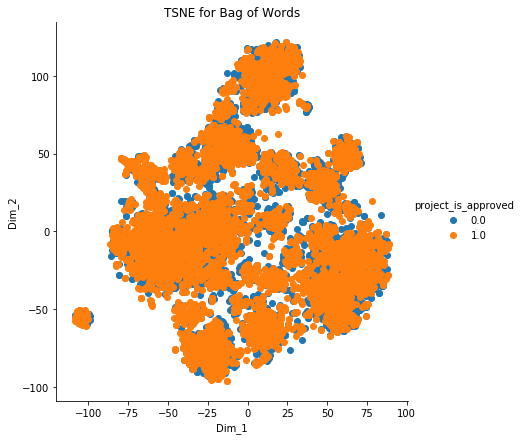

In [133]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 30, n_iter = 5000, verbose=10)

# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(X_feature)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, label_approved)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "project_is_approved"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="project_is_approved", height=6).map(plt.scatter, "Dim_1", "Dim_2").add_legend()
plt.title("TSNE for Bag of Words")
plt.show()

## NOTE:
1. After merging the categorical data + numerical data + text data(project_title) the number of data points are: 10000 and the dimensionality of the matrix is : 760
2. There is a lot of overlapping between the approved and not approved projects.
3. Clusters are not informative because they are not well separated.
4. On changing the values of the parameters : perplexity and number of iterations, there is not much significant changes.
5. The data points are not linearly separable and thats why we can't draw a hyperplane to separate the data points.

<h2> 2.2 TSNE with `TFIDF` encoding of `project_title` feature </h2>

### Vectorizing Text Data (TFIDF)

In [134]:
#TFIDF
# Project Title

vectorizer = TfidfVectorizer(min_df=10)
project_title_tfidf = vectorizer.fit_transform(preprocessed_project_title)
print("Shape of matrix after one hot encodig ",project_title_tfidf.shape)

Shape of matrix after one hot encodig  (10000, 664)


<h3><font color='red'>Merging the categorical, numerical features + project_title(TFIDF)</font></h3> 

In [135]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X = hstack((categories_one_hot, sub_categories_one_hot, 
            school_state_one_hot, project_grades_one_hot, project_title_tfidf,
            price_standardized, previous_post_standardized))
X.shape

(10000, 760)

In [136]:
# Converting the scipy.sparse.coo.coo_matrix to dense matrix as TSNE accepts only dense matrix
# Reference : https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.coo_matrix.todense.html

X_feature = X.todense()

<h3><font color='red'>Plotting the T-SNE (TFIDF)</font></h3> 

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.333s...
[t-SNE] Computed neighbors for 10000 samples in 157.997s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.696956
[t-SNE] Computed conditional probabilities in 0.463s
[t-SNE] Iteration 50: error = 97.0941467, gradient norm = 0.0037403 (50 iterations in 9.991s)
[t-SNE] 

[t-SNE] Iteration 3900: error = 1.3948741, gradient norm = 0.0000295 (50 iterations in 4.582s)
[t-SNE] Iteration 3950: error = 1.3945652, gradient norm = 0.0000295 (50 iterations in 4.604s)
[t-SNE] Iteration 4000: error = 1.3943057, gradient norm = 0.0000307 (50 iterations in 4.589s)
[t-SNE] Iteration 4050: error = 1.3940897, gradient norm = 0.0000291 (50 iterations in 4.602s)
[t-SNE] Iteration 4100: error = 1.3938459, gradient norm = 0.0000310 (50 iterations in 4.590s)
[t-SNE] Iteration 4150: error = 1.3936913, gradient norm = 0.0000267 (50 iterations in 4.635s)
[t-SNE] Iteration 4200: error = 1.3934644, gradient norm = 0.0000279 (50 iterations in 4.624s)
[t-SNE] Iteration 4250: error = 1.3932486, gradient norm = 0.0000273 (50 iterations in 4.643s)
[t-SNE] Iteration 4300: error = 1.3930273, gradient norm = 0.0000244 (50 iterations in 5.889s)
[t-SNE] Iteration 4350: error = 1.3928429, gradient norm = 0.0000231 (50 iterations in 6.070s)
[t-SNE] Iteration 4400: error = 1.3925735, gradien

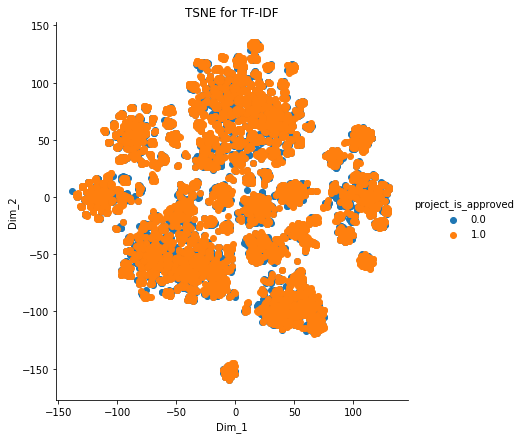

In [137]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 30, n_iter = 5000, verbose=10)

# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(X_feature)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, label_approved)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "project_is_approved"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="project_is_approved", height=6).map(plt.scatter, "Dim_1", "Dim_2").add_legend()
plt.title("TSNE for TF-IDF")
plt.show()

## NOTE:
1. After merging the categorical data + numerical data + text data(project_title) the number of data points are: 10000 and the dimensionality of the matrix is : 760
2. There is a lot of overlapping between the approved and not approved projects.
3. Clusters are not informative because they are not well separated.
4. On changing the values of the parameters : perplexity and number of iterations, there is not much significant changes.
5. The data points are not linearly separable and thats why we can't draw a hyperplane to separate the data points.
6. The plot looks similar to that of Bag of words representation.

<h2> 2.3 TSNE with `AVG W2V` encoding of `project_title` feature </h2>

### Vectorizing Text Data (AVG W2V)

In [138]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())


# Project Title avg w2v
avg_w2v_vectors_project_title = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_project_title): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_project_title.append(vector)

print(len(avg_w2v_vectors_project_title))
print(len(avg_w2v_vectors_project_title[0]))

100%|██████████| 10000/10000 [00:00<00:00, 57223.09it/s]

10000
300


<h3><font color='red'>Merging the categorical, numerical features + project_title(AVG W2V)</font></h3> 

In [139]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X = hstack((categories_one_hot, sub_categories_one_hot, 
            school_state_one_hot, project_grades_one_hot, avg_w2v_vectors_project_title,
            price_standardized, previous_post_standardized))
X.shape

(10000, 396)

In [140]:
# Converting the scipy.sparse.coo.coo_matrix to dense matrix as TSNE accepts only dense matrix
# Reference : https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.coo_matrix.todense.html

X_feature = X.todense()

<h3><font color='red'>Plotting the T-SNE (AVG W2V)</font></h3>

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.152s...
[t-SNE] Computed neighbors for 10000 samples in 97.415s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.095176
[t-SNE] Computed conditional probabilities in 0.469s
[t-SNE] Iteration 50: error = 94.8703003, gradient norm = 0.0000180 (50 iterations in 8.487s)
[t-SNE] I

[t-SNE] Iteration 3900: error = 2.6515512, gradient norm = 0.0000155 (50 iterations in 5.483s)
[t-SNE] Iteration 3950: error = 2.6512978, gradient norm = 0.0000157 (50 iterations in 5.487s)
[t-SNE] Iteration 4000: error = 2.6510341, gradient norm = 0.0000152 (50 iterations in 5.449s)
[t-SNE] Iteration 4050: error = 2.6507297, gradient norm = 0.0000153 (50 iterations in 5.442s)
[t-SNE] Iteration 4100: error = 2.6504419, gradient norm = 0.0000159 (50 iterations in 5.477s)
[t-SNE] Iteration 4150: error = 2.6501944, gradient norm = 0.0000154 (50 iterations in 5.445s)
[t-SNE] Iteration 4200: error = 2.6499376, gradient norm = 0.0000148 (50 iterations in 5.488s)
[t-SNE] Iteration 4250: error = 2.6496456, gradient norm = 0.0000163 (50 iterations in 5.493s)
[t-SNE] Iteration 4300: error = 2.6493833, gradient norm = 0.0000160 (50 iterations in 5.524s)
[t-SNE] Iteration 4350: error = 2.6491265, gradient norm = 0.0000151 (50 iterations in 5.477s)
[t-SNE] Iteration 4400: error = 2.6489236, gradien

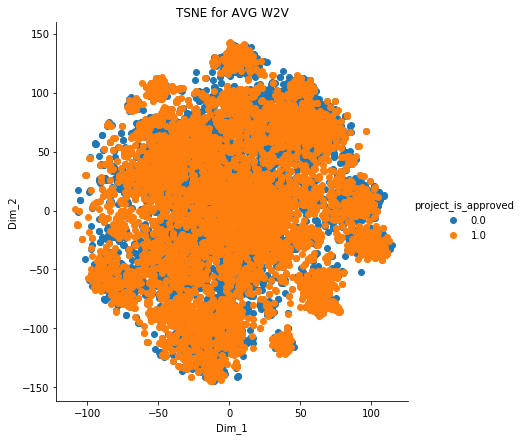

In [141]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 30, n_iter = 5000, verbose=10)

# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(X_feature)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, label_approved)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "project_is_approved"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="project_is_approved", height=6).map(plt.scatter, "Dim_1", "Dim_2").add_legend()
plt.title("TSNE for AVG W2V")
plt.show()

## NOTE:
1. We are using a pretrained model to get the average word2vec.
2. The number of dimensions in the data matrix is : 396, after merging all the features and the number of data points remains the same 10000
3. The above graph is also not linearly separable and we can't draw a hyperplane to separate the dense points in the data matrix.
4. As T-SNE accepts only dense matrix so after merging all the features we have to convert it into dense matrix.
5. We converted the 396 dimension matrix and plotted it in 2-Dimensions using T-SNE

<h2> 2.4 TSNE with `TFIDF Weighted W2V` encoding of `project_title` feature </h2>

### Vectorizing Text Data (TFIDF Weighted W2V)

In [142]:
# Project Title
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_project_title)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())



# Project Title
tfidf_w2v_vectors_project_title = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_project_title): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_project_title.append(vector)

print(len(tfidf_w2v_vectors_project_title))
print(len(tfidf_w2v_vectors_project_title[0]))

  0%|          | 0/10000 [00:00<?, ?it/s]


TypeError: 'TSNE' object is not subscriptable

<h3><font color='red'>Merging the categorical, numerical features + project_title(TFIDF Weighted W2V)</font></h3> 

In [ ]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X = hstack((categories_one_hot, sub_categories_one_hot, 
            school_state_one_hot, project_grades_one_hot, tfidf_w2v_vectors_project_title,
            price_standardized, previous_post_standardized))
X.shape

In [ ]:
# Converting the scipy.sparse.coo.coo_matrix to dense matrix as TSNE accepts only dense matrix
# Reference : https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.coo_matrix.todense.html

X_feature = X.todense()

<h3><font color='red'>Plotting the T-SNE (TFIDF Weighted W2V)</font></h3>

In [ ]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 30, n_iter = 5000, verbose=10)

# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(X_feature)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, label_approved)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "project_is_approved"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="project_is_approved", height=6).map(plt.scatter, "Dim_1", "Dim_2").add_legend()
plt.title("TSNE for TFIDF Weighted W2V")
plt.show()

## NOTE:
1. We are using a pretrained model to get the average word2vec.
2. The number of dimensions in the data matrix is : 396, after merging all the features and the number of data points remains the same 10000
3. The above graph is also not linearly separable and we can't draw a hyperplane to separate the dense points in the data matrix.
4. As T-SNE accepts only dense matrix so after merging all the features we have to convert it into dense matrix.
5. We converted the 396 dimension matrix and plotted it in 2-Dimensions using T-SNE
6. The plot is similar to AVG W2V and its difficult to draw any conclusion from this graph.

<h2> 2.5 Summary </h2>

1. None of the T-SNE representation gave any well separation between the data points
2. We simply can't give any conclusion based on the above results as we can't draw any hyperplane in any of the representations to differentiate the two different classes.
3. We have to convert the data matrix before applying T-SNE because T-SNE accepts only dense matrices
4. In BOW and TF-IDF the number of dimensions were more (i.e 760) comapred to AVG W2V and TF-IDF weighted W2V which had 396 dimensions.
5. BOW and TF-IDF have similar plots. Also AVG W2V and TF-IDF weighted W2V have similar plots.
6. We need to apply some different techniques or methods to separate the approved and not approved projects.